In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from scipy.integrate import odeint, solve_ivp

from dataset import Dataset
import NeuralNet 

%load_ext autoreload
%autoreload 2

In [2]:
files = os.listdir('../Bioindustry/data/')
files = [f for f in files if f.startswith('BR')]
files.sort()

def get_data(files: list) -> pd.DataFrame:
    dfs = []
    for i, file in enumerate(files):
        df = pd.read_excel(f'../Bioindustry/data/{file}', header=0)
        df = df[1:]
        df['BR'] = i+1
        dfs.append(df)
    return pd.concat(dfs)

df = get_data(files)
df = df[df['Batch'] == 0]
df.to_csv('data_ceasar.csv')

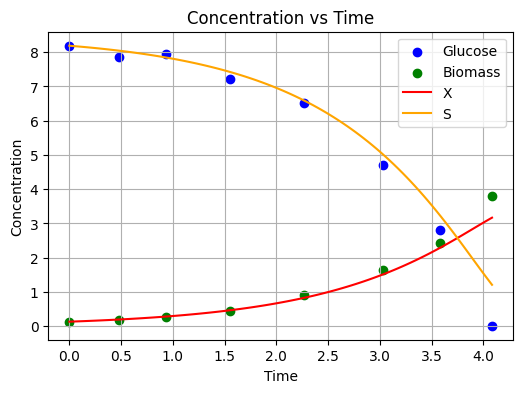

In [3]:
d =Dataset()
d.get_data(exp=1)

# Solve for 0.6794, 0.0002, 0.2572 kinetic parameter values
# mu_max_hat: 0.903, Km_hat: 0.826, Y_XS_hat: 0.435
sol = d.solve_ode(mu_max=0.903, Km=0.826, Y_XS=0.435)
d.plot_solution(sol)

# # Generate training data
# train_df = d.training_dataset(N=5000)
# print(f'Train data shape: {train_df.shape}')

In [16]:
# X, y = NeuralNet.preprocess_data(train_df)
# net = NeuralNet.NN(input_dim=2*d.df.shape[1])

# losses_train = []
# losses_val = []
# for i in range(5000):
#     loss_train = net.train(X, y)    
#     losses_train.append(loss_train)
#     if i % 500 == 0:
#         print(f'Epoch: {i}, Loss: {loss_train}')

In [17]:
# # Evaluate on df experimental data
# X_test, S_test = d.df['Biomass'].values, d.df['Glucose'].values

# X_test, S_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(S_test, dtype=torch.float32)
# test_df = torch.hstack((X_test, S_test)).view(1,-1)

# # Predict
# mu_max, Km, Y_XS = net.predict(test_df).detach().numpy().flatten()
# print(f'Predicted mu_max: {mu_max}, Km: {Km}, Y_XS: {Y_XS}')

In [18]:
# sol = d.solve_ode(mu_max=mu_max, Km=Km, Y_XS=Y_XS)
# d.plot_solution(sol)

## PINN

In [19]:
from PINN import PINN, get_loss

%load_ext autoreload
%autoreload 2

pinn = PINN(1, 2, T_START=d.df['Time'].min(), T_END=d.df['Time'].max())
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)
criterion = nn.MSELoss()

t_train = d.df['Time'].values
u_train = d.df[['Biomass', 'Glucose']].values

# Train data to tensor
ts_train = torch.tensor(t_train, requires_grad=True).float().view(-1,1)
us_train = torch.tensor(u_train, requires_grad=True).float()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
EPOCHS = 10000
LOSS = []
for epoch in range(EPOCHS):
    u_pred = pinn(ts_train)
    residual_pred = get_loss(pinn)
    loss = criterion(u_pred, us_train)
    loss += 0.5*residual_pred
    LOSS.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}, ODE Loss: {torch.mean(residual_pred).item()}')

Epoch: 0, Loss: 19.790435791015625, ODE Loss: 0.03862655535340309
Epoch: 500, Loss: 3.079847574234009, ODE Loss: 0.467435747385025
Epoch: 1000, Loss: 0.9007428884506226, ODE Loss: 0.5588209629058838
Epoch: 1500, Loss: 0.6299452781677246, ODE Loss: 0.4257045090198517
Epoch: 2000, Loss: 0.44201773405075073, ODE Loss: 0.29283732175827026
Epoch: 2500, Loss: 0.30425089597702026, ODE Loss: 0.189511239528656
Epoch: 3000, Loss: 0.20430943369865417, ODE Loss: 0.11498171836137772
Epoch: 3500, Loss: 0.13368834555149078, ODE Loss: 0.06482914835214615
Epoch: 4000, Loss: 0.08716776221990585, ODE Loss: 0.03673727810382843
Epoch: 4500, Loss: 0.06041266396641731, ODE Loss: 0.02635059505701065
Epoch: 5000, Loss: 0.04550475627183914, ODE Loss: 0.022536616772413254
Epoch: 5500, Loss: 0.03577185422182083, ODE Loss: 0.01902984082698822
Epoch: 6000, Loss: 0.028547396883368492, ODE Loss: 0.015596713870763779
Epoch: 6500, Loss: 0.023024598136544228, ODE Loss: 0.012844781391322613
Epoch: 7000, Loss: 0.018708910

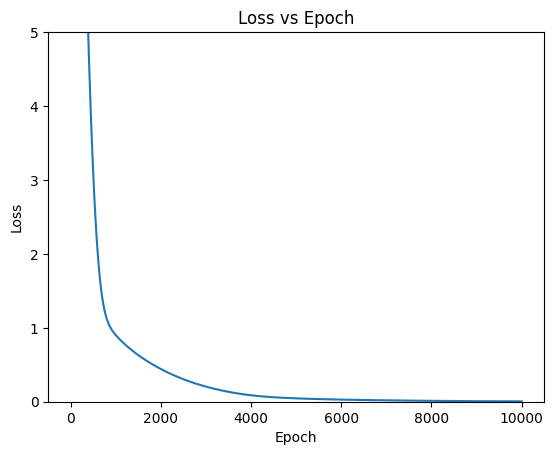

In [21]:
plt.plot(LOSS, label='Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 5)
plt.title('Loss vs Epoch')
plt.show()

In [23]:
print(f'mu_max: {pinn.mu_max.item()}, Km: {pinn.Km.item()}, Y_XS: {pinn.Y_XS.item()}')

mu_max: 0.796343207359314, Km: 0.0014175199903547764, Y_XS: 0.444271057844162


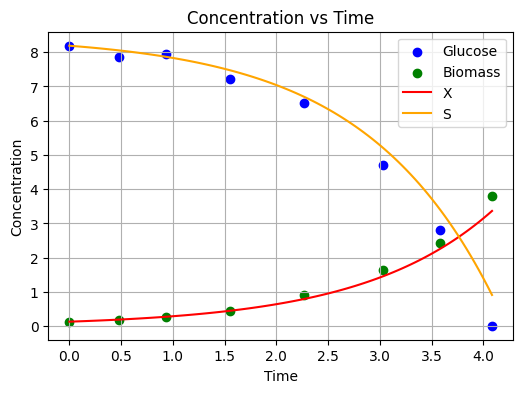

In [24]:
sol_pinn = d.solve_ode(mu_max=pinn.mu_max.item(), Km=pinn.Km.item(), Y_XS=pinn.Y_XS.item())
d.plot_solution(sol_pinn)